<a href="https://colab.research.google.com/github/SanjayRamSingh/Dominos---Predictive-Purchase-Order-System/blob/main/Dominos_Predictive_Purchase_Order_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pizza_df = pd.read_excel('/content/Pizza_Sale.xlsx')
ingred_df = pd.read_excel('/content/Pizza_ingredients.xlsx')

In [ ]:
pizza_df.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,2015-01-01 00:00:00,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,2015-01-01 00:00:00,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,2015-01-01 00:00:00,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [ ]:
pizza_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pizza_id           48620 non-null  int64  
 1   order_id           48620 non-null  int64  
 2   pizza_name_id      48604 non-null  object 
 3   quantity           48620 non-null  int64  
 4   order_date         48620 non-null  object 
 5   order_time         48620 non-null  object 
 6   unit_price         48620 non-null  float64
 7   total_price        48613 non-null  float64
 8   pizza_size         48620 non-null  object 
 9   pizza_category     48597 non-null  object 
 10  pizza_ingredients  48607 non-null  object 
 11  pizza_name         48613 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 4.5+ MB


In [ ]:
pizza_df.isna().sum()

,0
pizza_id,0
order_id,0
pizza_name_id,16
quantity,0
order_date,0
order_time,0
unit_price,0
total_price,7
pizza_size,0
pizza_category,23


In [ ]:
pizza_df.dropna(inplace=True)

In [ ]:
pizza_df.isna().sum()

,0
pizza_id,0
order_id,0
pizza_name_id,0
quantity,0
order_date,0
order_time,0
unit_price,0
total_price,0
pizza_size,0
pizza_category,0


In [ ]:
pizza_df.duplicated().sum()

0

In [ ]:
pizza_df.shape

(48554, 12)

In [ ]:
def parse_dates(date):
  for fmt in ('%d-%m-%Y', '%d/%m/%Y'):
    try:
      return pd.to_datetime(date, format=fmt)
    except ValueError:
      pass
  raise ValueError(f'no valid date format found for {date}')

In [ ]:
pizza_df['order_date'] = pizza_df['order_date'].apply(parse_dates)

In [ ]:
pizza_df['order_date'].head()

,order_date
0,2015-01-01
1,2015-01-01
2,2015-01-01
3,2015-01-01
4,2015-01-01


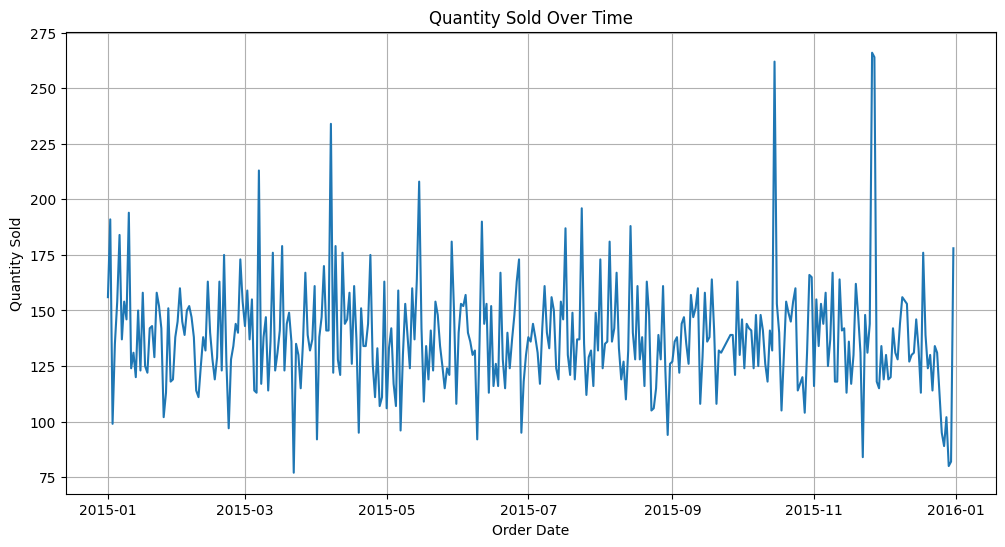

In [14]:
# Group by order date and sum the quantity
quantity_over_time = pizza_df.groupby('order_date')['quantity'].sum()

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(quantity_over_time.index, quantity_over_time.values)
plt.xlabel('Order Date')
plt.ylabel('Quantity Sold')
plt.title('Quantity Sold Over Time')
plt.grid(True)
plt.show()

# Autocorrelation and partial Autocorrelation

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

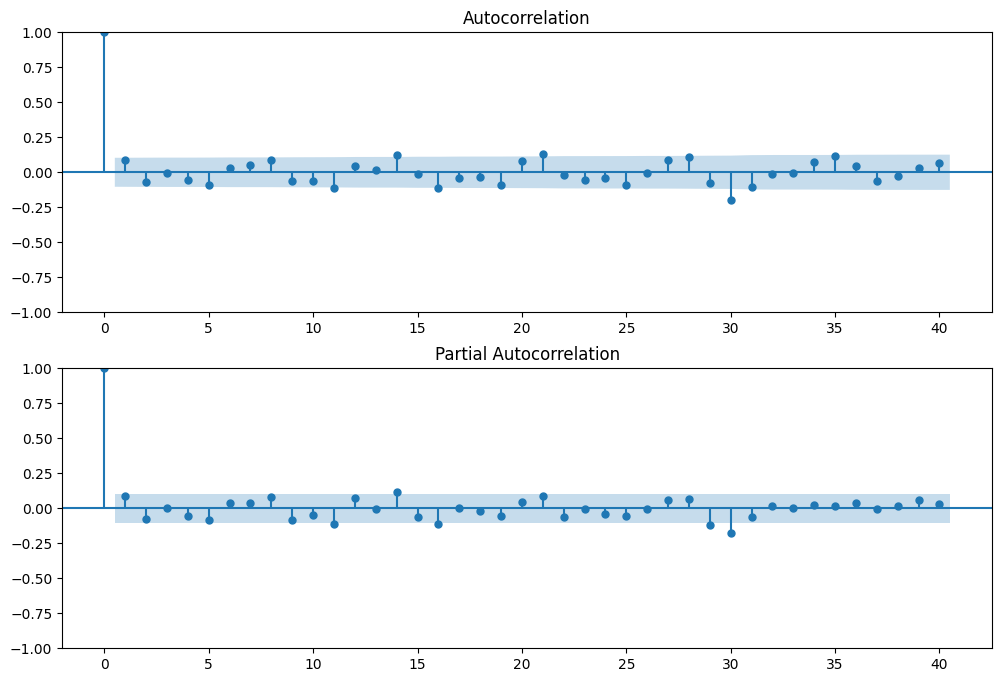

In [16]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(quantity_over_time, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(quantity_over_time, lags=40, ax=ax2)

In [17]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
# H0: it is not stationary
# H1: it is stationary

In [18]:
def adf_test(sales):
  result = adfuller(sales)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print(f'# Lags used: {result[2]}')
  print(f'No of observations used: {result[3]}')
  if result[1] <= 0.05:
    print('we reject the null hypothesis, The series is stationary')
  else:
    print('Not enough statistical evidence to reject null hypothesis, The series is not stationary')

In [19]:
adf_test(quantity_over_time)

ADF Statistic: -4.919389
p-value: 0.000032
# Lags used: 15
No of observations used: 342
we reject the null hypothesis, The series is stationary


In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [21]:
eval_data = pizza_df.groupby(['order_date', 'pizza_name'])['quantity'].sum().unstack().fillna(0)

In [22]:
eval_data.head()

pizza_name,The Barbecue Chicken Pizza,The Big Meat Pizza,The Brie Carre Pizza,The Calabrese Pizza,The California Chicken Pizza,The Chicken Alfredo Pizza,The Chicken Pesto Pizza,The Classic Deluxe Pizza,The Five Cheese Pizza,The Four Cheese Pizza,...,The Prosciutto and Arugula Pizza,The Sicilian Pizza,The Soppressata Pizza,The Southwest Chicken Pizza,The Spicy Italian Pizza,The Spinach Pesto Pizza,The Spinach Supreme Pizza,The Spinach and Feta Pizza,The Thai Chicken Pizza,The Vegetables + Vegetables Pizza
order_date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,11.0,5.0,0.0,1.0,4.0,2.0,4.0,10.0,6.0,5.0,...,4.0,4.0,0.0,7.0,5.0,2.0,5.0,2.0,7.0,3.0
2015-01-02,12.0,9.0,3.0,7.0,15.0,3.0,2.0,13.0,5.0,6.0,...,6.0,5.0,3.0,9.0,9.0,5.0,3.0,4.0,8.0,1.0
2015-01-03,2.0,3.0,1.0,1.0,6.0,0.0,1.0,4.0,5.0,4.0,...,1.0,2.0,0.0,9.0,4.0,3.0,0.0,5.0,4.0,6.0
2015-01-04,2.0,3.0,0.0,2.0,3.0,3.0,2.0,8.0,7.0,6.0,...,4.0,8.0,6.0,10.0,4.0,4.0,6.0,1.0,3.0,5.0
2015-01-05,6.0,1.0,1.0,4.0,11.0,2.0,5.0,9.0,6.0,4.0,...,5.0,5.0,0.0,6.0,5.0,2.0,4.0,5.0,10.0,6.0


In [23]:
one_pizza = eval_data['The Barbecue Chicken Pizza']

In [24]:
# split train and test
train = one_pizza[:-7]
test = one_pizza[-7:]

In [25]:
# Fit Arima model
ari_model = ARIMA(train, order=(1, 1, 0))
ari_result = ari_model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [26]:
# forecast
ari_forecast = ari_result.get_forecast(steps=len(test))
ari_fore_values = ari_forecast.predicted_mean

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [27]:
ari_predict = ari_result.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [31]:
ari_predict.index = test.index

In [32]:
# concat test and ari_predict without changing the index of test, test is a pandas series

concatenated_series = pd.concat([test, ari_predict], axis=1)
concatenated_series.columns = ['Actual', 'Predicted']
concatenated_series

,Actual,Predicted
order_date,,
2015-12-24,4.0,5.084266
2015-12-26,5.0,5.503550
2015-12-27,4.0,5.311574
2015-12-28,2.0,5.399474
2015-12-29,4.0,5.359227
2015-12-30,6.0,5.377655
2015-12-31,10.0,5.369217


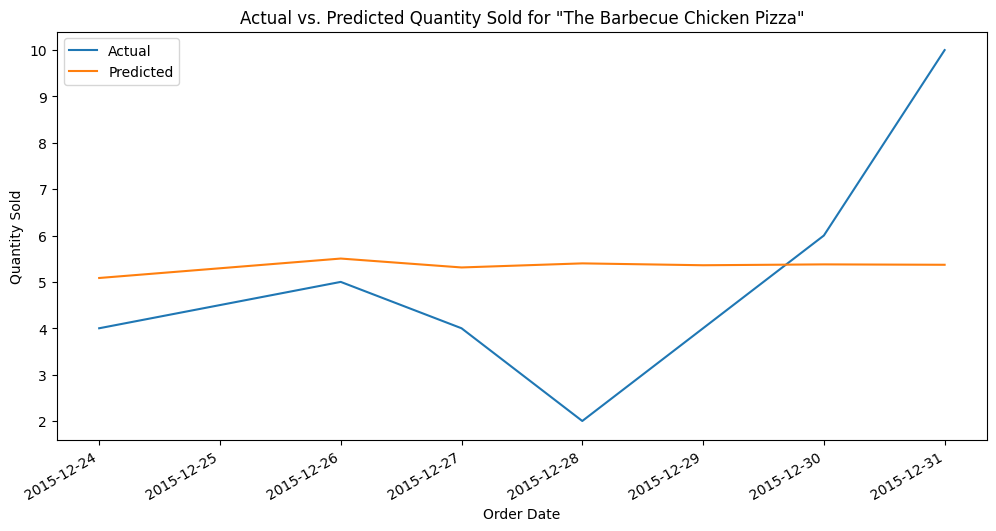

In [33]:
concatenated_series.plot(figsize=(12, 6))
plt.xlabel('Order Date')
plt.ylabel('Quantity Sold')
plt.title('Actual vs. Predicted Quantity Sold for "The Barbecue Chicken Pizza"')
plt.show()

In [34]:
# Evaluate the model
mae = mean_absolute_error(test, ari_fore_values)
mse = mean_squared_error(test, ari_fore_values)
rmse = np.sqrt(mse)

print(f'ARIMA MAE: {mae}')
print(f'ARIMA MSE: {mse}')
print(f'ARIMA RMSE: {rmse}')

ARIMA MAE: 1.8444598200710796
ARIMA MSE: 5.4835431682341005
ARIMA RMSE: 2.341696643084689


In [35]:
# fit SARIMA model
sari_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
sari_result = sari_model.fit()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [36]:
# sarima forecast
sari_forecast = sari_result.get_forecast(steps=len(test))
sari_fore_values = sari_forecast.predicted_mean

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [37]:
# Evaluate Sarima
mae = mean_absolute_error(test, sari_fore_values)
mse = mean_squared_error(test, sari_fore_values)
rmse = np.sqrt(mse)

print(f'SARIMAX MAE: {mae}')
print(f'SARIMAX MSE: {mse}')
print(f'SARIMAX RMSE: {rmse}')

SARIMAX MAE: 2.4494962419985193
SARIMAX MSE: 7.643175436020916
SARIMAX RMSE: 2.7646293487592355


In [38]:
sari_predict = sari_result.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [39]:
sari_predict.index = test.index

In [40]:
sari_predict

,predicted_mean
order_date,
2015-12-24,7.519956
2015-12-26,6.311427
2015-12-27,5.876091
2015-12-28,6.495620
2015-12-29,6.131548
2015-12-30,6.517850
2015-12-31,6.706018


In [41]:
concatenated_sarima = pd.concat([test, sari_predict] , axis=1)
concatenated_sarima.columns = ['Actual', 'Predicted']
concatenated_sarima

,Actual,Predicted
order_date,,
2015-12-24,4.0,7.519956
2015-12-26,5.0,6.311427
2015-12-27,4.0,5.876091
2015-12-28,2.0,6.495620
2015-12-29,4.0,6.131548
2015-12-30,6.0,6.517850
2015-12-31,10.0,6.706018


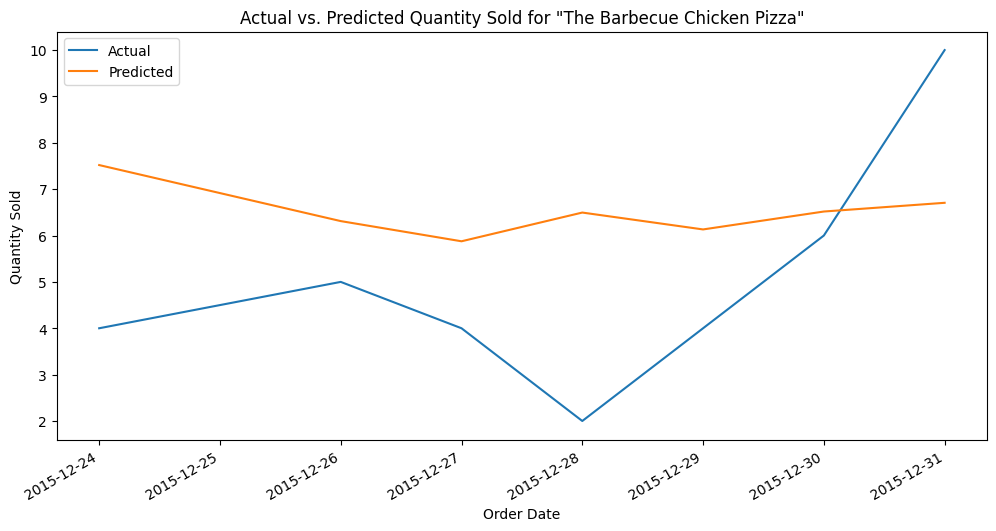

In [42]:
concatenated_sarima.plot(figsize=(12, 6))
plt.xlabel('Order Date')
plt.ylabel('Quantity Sold')
plt.title('Actual vs. Predicted Quantity Sold for "The Barbecue Chicken Pizza"')
plt.show()

# Prophet Evaluation

In [43]:
pip install prophet

In [44]:
from prophet import Prophet

In [45]:
one_pizza_prophet = pd.DataFrame({'ds': one_pizza.index, 'y': one_pizza.values})

one_pizza_prophet.head()

,ds,y
0,2015-01-01,11.0
1,2015-01-02,12.0
2,2015-01-03,2.0
3,2015-01-04,2.0
4,2015-01-05,6.0


In [46]:
# one_pizza_prophet.set_index('ds', inplace=True)

# split train and test
pr_train = one_pizza_prophet[:-7]
pr_test = one_pizza_prophet[-7:]

In [47]:
# fit model prophet
pr_model = Prophet()
pr_model.fit(pr_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0g_wspfg/t5pmt3vl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0g_wspfg/uu9e93r7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=877', 'data', 'file=/tmp/tmp0g_wspfg/t5pmt3vl.json', 'init=/tmp/tmp0g_wspfg/uu9e93r7.json', 'output', 'file=/tmp/tmp0g_wspfg/prophet_modelzjdww8wq/prophet_model-20250209091413.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:14:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:14:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [48]:
# forcast for one week
pr_future = pr_model.make_future_dataframe(periods=7, freq='D')
pr_forecast = pr_model.predict(pr_future)

In [49]:
# extract forecast values
pr_forecast_values = pr_forecast['yhat'][-len(pr_test):].values

In [50]:
# Evaluate the model
mae = mean_absolute_error(pr_test['y'], pr_forecast_values)
mse = mean_squared_error(pr_test['y'], pr_forecast_values)
rmse = np.sqrt(mse)

print(f'prophet MAE: {mae}')
print(f'prophet MSE: {mse}')
print(f'prophet RMSE: {rmse}')

prophet MAE: 2.649386800009464
prophet MSE: 8.228845649774026
prophet RMSE: 2.868596459904046


In [51]:
concat_prophet = pd.concat([pr_test, pr_forecast[['yhat']].iloc[-len(pr_test):]], axis=1)
concat_prophet.columns = ['date','Actual', 'Predicted']
concat_prophet.set_index('date', inplace=True)
concat_prophet

,Actual,Predicted
date,,
2015-12-24,4.0,7.179763
2015-12-26,5.0,7.675124
2015-12-27,4.0,6.737146
2015-12-28,2.0,5.499091
2015-12-29,4.0,6.180004
2015-12-30,6.0,6.305528
2015-12-31,10.0,6.030950


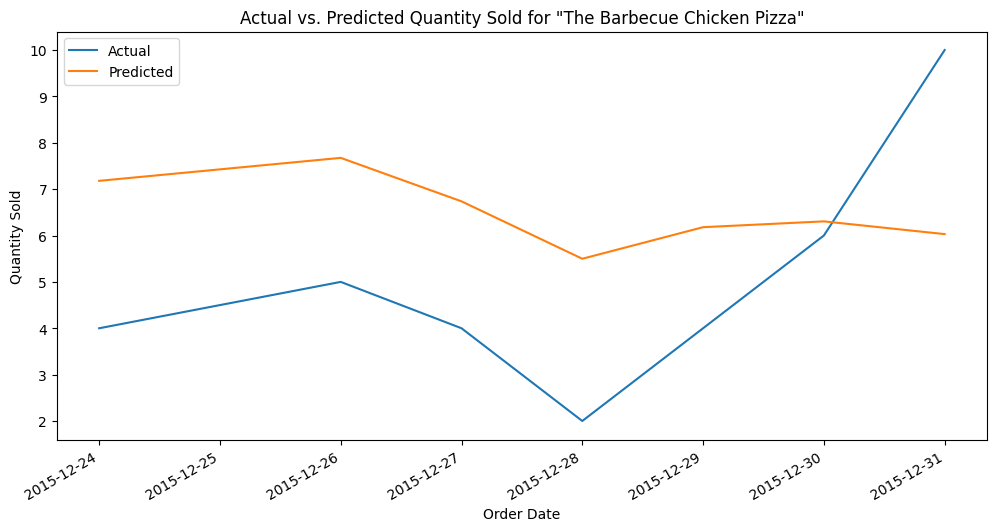

In [52]:
# visualize forecast
concat_prophet.plot(figsize=(12, 6))
plt.xlabel('Order Date')
plt.ylabel('Quantity Sold')
plt.title('Actual vs. Predicted Quantity Sold for "The Barbecue Chicken Pizza"')
plt.show()

In [53]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import LabelEncoder

In [54]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [55]:
pizza_df = pd.read_excel('/content/Pizza_Sale.xlsx')
ingred_df = pd.read_excel('/content/Pizza_ingredients.xlsx')

In [56]:
pizza_df.dropna(inplace=True)

In [57]:
def parse_dates(date):
  for fmt in ('%d-%m-%Y', '%d/%m/%Y'):
    try:
      return pd.to_datetime(date, format=fmt)
    except ValueError:
      pass
  raise ValueError(f'no valid date format found for {date}')

In [58]:
pizza_df['order_date'] = pizza_df['order_date'].apply(parse_dates)

In [59]:
pizza_df = pizza_df[['order_date', 'pizza_name', 'quantity']]

In [ ]:
# pizza_df['pizza_name'].unique()

In [60]:
sales_summary = pizza_df.groupby(['order_date', 'pizza_name']).sum().reset_index()

In [61]:
sales_summary.head()

,order_date,pizza_name,quantity
0,2015-01-01,The Barbecue Chicken Pizza,11
1,2015-01-01,The Big Meat Pizza,5
2,2015-01-01,The Calabrese Pizza,1
3,2015-01-01,The California Chicken Pizza,4
4,2015-01-01,The Chicken Alfredo Pizza,2


In [62]:
# reshape data for time series modeling
sales_pivot = sales_summary.pivot(index='order_date', columns='pizza_name', values='quantity').fillna(0)

In [63]:
arima_models = {}

for pizza_name in sales_pivot.columns:
  try:
    model = ARIMA(sales_pivot[pizza_name], order=(1, 1, 0))
    model_fit = model.fit()
    arima_models[pizza_name] = model_fit
  except:
    print(f'ARIMA model for {pizza_name} failed to fit')

In [64]:
# Generate predictions for one week
prediction_days = 7
predictions_arima = {}

for pizza_name, model in arima_models.items():
  predictions_arima[pizza_name] = model.predict(start=len(sales_pivot), end=len(sales_pivot) + prediction_days - 1)

In [65]:
predictions_df = pd.DataFrame(predictions_arima)

In [66]:
predictions_df.index = pd.date_range(start=sales_pivot.index[-1], periods=prediction_days, freq='D')

In [67]:
ingredients_df = ingred_df[['pizza_name', 'pizza_ingredients', 'Items_Qty_In_Grams']]

In [68]:
# change column name to items_qty
ingredients_df.rename(columns={'Items_Qty_In_Grams': 'items_qty'}, inplace=True)

In [69]:
predictions_df

,The Barbecue Chicken Pizza,The Big Meat Pizza,The Brie Carre Pizza,The Calabrese Pizza,The California Chicken Pizza,The Chicken Alfredo Pizza,The Chicken Pesto Pizza,The Classic Deluxe Pizza,The Five Cheese Pizza,The Four Cheese Pizza,...,The Prosciutto and Arugula Pizza,The Sicilian Pizza,The Soppressata Pizza,The Southwest Chicken Pizza,The Spicy Italian Pizza,The Spinach Pesto Pizza,The Spinach Supreme Pizza,The Spinach and Feta Pizza,The Thai Chicken Pizza,The Vegetables + Vegetables Pizza
2015-12-31,8.177936,4.359358,0.888944,1.432509,7.0,2.416310,2.102540,7.119636,2.904758,7.036754,...,3.440253,2.287110,2.033516,5.917653,6.042423,3.472261,2.0,3.171529,3.0,7.835581
2016-01-01,9.007915,5.256593,1.506167,2.251518,7.0,3.252335,3.002629,8.502385,4.002268,8.000338,...,4.251190,3.759064,2.500562,5.496609,7.292032,4.250256,2.0,4.007356,3.0,8.772523
2016-01-02,8.629846,4.765913,1.163282,1.823589,7.0,2.811000,2.575658,7.838582,3.427381,7.527399,...,3.829571,2.960415,2.274866,5.689795,6.764059,3.854065,2.0,3.625284,3.0,8.366936
2016-01-03,8.802063,5.034256,1.353764,2.047181,7.0,3.043979,2.778198,8.157248,3.728513,7.759523,...,4.048777,3.393744,2.383932,5.601157,6.987133,4.055824,2.0,3.799936,3.0,8.542508
2016-01-04,8.723615,4.887505,1.247946,1.930355,7.0,2.920990,2.682120,8.004269,3.570777,7.645594,...,3.934809,3.158629,2.331226,5.641826,6.892882,3.953079,2.0,3.720099,3.0,8.466505
2016-01-05,8.759349,4.967760,1.306731,1.991396,7.0,2.985916,2.727696,8.077708,3.653400,7.701512,...,3.994063,3.286197,2.356696,5.623166,6.932704,4.005401,2.0,3.756594,3.0,8.499406
2016-01-06,8.743072,4.923870,1.274074,1.959502,7.0,2.951642,2.706076,8.042453,3.610121,7.674067,...,3.963256,3.216982,2.344388,5.631728,6.915879,3.978756,2.0,3.739912,3.0,8.485164


In [70]:
ingredients_df.head()

,pizza_name,pizza_ingredients,items_qty
0,The Barbecue Chicken Pizza,Barbecued Chicken,40.0
1,The Barbecue Chicken Pizza,Red Peppers,15.0
2,The Barbecue Chicken Pizza,Green Peppers,20.0
3,The Barbecue Chicken Pizza,Tomatoes,30.0
4,The Barbecue Chicken Pizza,Red Onions,60.0


In [71]:
# Create a dictionary to store the ingredient quantities
ingredient_quantities = {}

# Iterate through each pizza in the predictions
for pizza_name in predictions_df.columns:
  # Get the predicted quantity for the pizza
  predicted_quantity = predictions_df[pizza_name].sum()

  # Get the ingredients for the pizza
  pizza_ingredients = ingredients_df[ingredients_df['pizza_name'] == pizza_name]

  # Iterate through each ingredient for the pizza
  for index, row in pizza_ingredients.iterrows():
    ingredient = row['pizza_ingredients']
    ingredient_qty = row['items_qty']

    # Calculate the required quantity of the ingredient
    required_quantity = predicted_quantity * ingredient_qty

    # Add the required quantity to the dictionary
    if ingredient not in ingredient_quantities:
      ingredient_quantities[ingredient] = 0
    ingredient_quantities[ingredient] += required_quantity

In [72]:
# Create a DataFrame from the ingredient quantities
ingredient_requirements_df = pd.DataFrame.from_dict(ingredient_quantities, orient='index', columns=['required_quantity'])

In [73]:
# Print the ingredient requirements
ingredient_requirements_df

,required_quantity
Barbecued Chicken,5475.941766
Red Peppers,11352.798791
Green Peppers,8098.953665
Tomatoes,34844.716601
Red Onions,54751.007524
...,...
Luganega Sausage,2647.457055
Onions,1323.728528
Soppressata Salami,4867.555670
Peperoncini verdi,1434.813346


In [74]:
# Create a purchase order DataFrame
purchase_order_df = ingredient_requirements_df.copy()

# Add a column for the unit of measure (assuming all ingredients are in grams)
purchase_order_df['unit'] = 'grams'

# Rename the columns for better readability
purchase_order_df = purchase_order_df.rename(columns={'required_quantity': 'quantity'})

# Add a header to the purchase order
print('Purchase Order:')
print('----------------')

# Print the purchase order table
print(purchase_order_df.to_string())

Purchase Order:
----------------
                                quantity   unit
Barbecued Chicken            5475.941766  grams
Red Peppers                 11352.798791  grams
Green Peppers                8098.953665  grams
Tomatoes                    34844.716601  grams
Red Onions                  54751.007524  grams
Barbecue Sauce               1825.313922  grams
Bacon                       20179.703908  grams
Pepperoni                   23923.636123  grams
Italian Sausage               341.952555  grams
Chorizo Sausage              1709.762775  grams
Brie Carre Cheese             262.227280  grams
Prosciutto                    262.227280  grams
Caramelized Onions                   NaN  grams
Pears                          87.409093  grams
Thyme                          43.704547  grams
Garlic                      17841.155611  grams
?duja Salami                 1612.325925  grams
Pancetta                     2418.488888  grams
Friggitello Peppers           403.081481  grams
Chicken